# Import Data

In [0]:
import os

!git clone https://github.com/jihoo-kim/Coronavirus-Dataset
PATIENT_PATH = "/content/Coronavirus-Dataset/patient.csv"

fatal: destination path 'Coronavirus-Dataset' already exists and is not an empty directory.


In [0]:
import os

!git clone https://github.com/ClementBM/Experiment_Coronavius.git
PYRAMID_PATH = "/content/Experiment_Coronavius/data/population-pyramid-south-korea.csv"

fatal: destination path 'Experiment_Coronavius' already exists and is not an empty directory.


In [0]:
import pandas as pd

df_korea_patients = pd.read_csv(PATIENT_PATH)
df_korea_population_pyramid = pd.read_csv(PYRAMID_PATH)

# EDA Patients

In [0]:
df_korea_patients.head()
display(df_korea_patients.head())
display(df_korea_patients.shape)
display(df_korea_patients.columns)
display(df_korea_patients.iloc[:10,:10].dtypes)

,id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state,age,age_range
0,1,female,1984.0,China,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released,36.0,35-39
1,2,male,1964.0,Korea,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released,56.0,55-59
2,3,male,1966.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released,54.0,50-54
3,4,male,1964.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released,56.0,55-59
4,5,male,1987.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released,33.0,30-34


(417, 17)

Index(['id', 'sex', 'birth_year', 'country', 'region', 'disease', 'group',
       'infection_reason', 'infection_order', 'infected_by', 'contact_number',
       'confirmed_date', 'released_date', 'deceased_date', 'state', 'age',
       'age_range'],
      dtype='object')

id                    int64
sex                  object
birth_year          float64
country              object
region               object
disease             float64
group                object
infection_reason     object
infection_order     float64
infected_by         float64
dtype: object

## Cleaning data

In [0]:
# drop sample if sex or birth_year is NaN
not_nan = df_korea_patients['birth_year'].notna() & df_korea_patients['sex'].notna()
df_korea_patients = df_korea_patients[not_nan]
# typo
df_korea_patients["sex"] = df_korea_patients["sex"].replace("feamle", "female")

df_korea_patients['age'] = 2020 - df_korea_patients['birth_year'] 

In [0]:
df_korea_patients.head()
display(df_korea_patients.head())
display(df_korea_patients.shape)
display(df_korea_patients.columns)
display(df_korea_patients.iloc[:10,:10].dtypes)

,id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state,age,age_range
0,1,female,1984.0,China,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released,36.0,35-39
1,2,male,1964.0,Korea,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released,56.0,55-59
2,3,male,1966.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released,54.0,50-54
3,4,male,1964.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released,56.0,55-59
4,5,male,1987.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released,33.0,30-34


(417, 17)

Index(['id', 'sex', 'birth_year', 'country', 'region', 'disease', 'group',
       'infection_reason', 'infection_order', 'infected_by', 'contact_number',
       'confirmed_date', 'released_date', 'deceased_date', 'state', 'age',
       'age_range'],
      dtype='object')

id                    int64
sex                  object
birth_year          float64
country              object
region               object
disease             float64
group                object
infection_reason     object
infection_order     float64
infected_by         float64
dtype: object

## Distribution

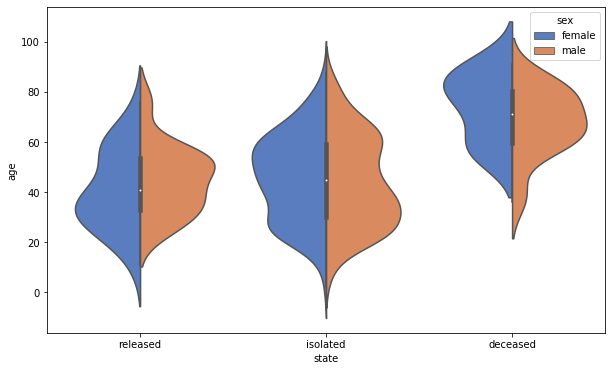

In [0]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.violinplot(x="state", y="age", hue="sex", data=df_korea_patients, palette="muted", split=True)
plt.show()

## Age pyramid

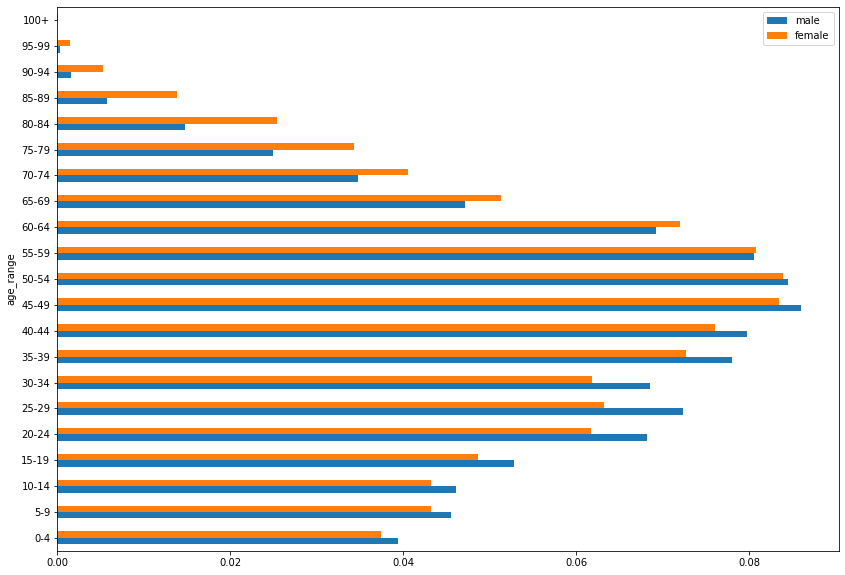

In [0]:
df_korea_population_pyramid.plot.barh(figsize=(14, 10), x="age_range")

### Adding age range 

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt

def group_age(age, window):
  if age > 99:
    return "100+"
  if age % 5 != 0:
      lower = int(math.floor(age / float(window))) * window
      upper = int(math.ceil(age / float(window))) * window - 1
      return f"{lower}-{upper}"
  else:
      lower = int(age)
      upper = int(age + window - 1) 
      return f"{lower}-{upper}"

def group_age_by_5(age):
  return group_age(age, 5)

In [0]:
df_korea_patients["age_range"] = df_korea_patients["age"].apply(group_age_by_5)

### Age range dictionary for ordering values

In [0]:
age_range_order = df_korea_population_pyramid["age_range"].to_dict()
age_range_order = {v: k for k, v in age_range_order.items()}

### Age pyramid proportion

In [0]:
total_male = sum(df_korea_population_pyramid.loc[:,'male'])
total_female = sum(df_korea_population_pyramid.loc[:,'female'])

df_korea_population_pyramid["male"] = df_korea_population_pyramid["male"] / total_male
df_korea_population_pyramid["female"] = df_korea_population_pyramid["female"] / total_female

In [0]:
def infected_population_normed(df):
  result = df.groupby(["age_range", "sex"], as_index=False)["age_range", "sex"].size()
  
  result = (
    pd.DataFrame(result)
    .pivot_table(index=["age_range"], columns=["sex"], fill_value=0.0)
    .reset_index()
  )

  result = result.set_index("age_range")
  
  result = result[0]
  result["order"] = [age_range_order[x] for x in result.index]
  result = result.sort_values(by="order")
  
  indices = [age_range_order[x] for x in result.index]
  df_normed = pd.DataFrame(index=df_korea_population_pyramid["age_range"], columns=["male","female"])

  df_normed.loc[result.index, "male"] = result["male"] / df_korea_population_pyramid.loc[indices]["male"].values
  df_normed.loc[result.index, "female"] = result["female"] / df_korea_population_pyramid.loc[indices]["female"].values

  df_normed = df_normed.replace(np.inf, 0)
  df_normed = df_normed.replace(np.nan, 0)

  df_normed["male"] = df_normed["male"] * 100 / sum(df_normed["male"])
  df_normed["female"] = df_normed["female"] * 100 / sum(df_normed["female"])

  distribution_normed = pd.DataFrame({'male': df_normed["male"], 'female': df_normed["female"]})
  distribution_normed = distribution_normed.reset_index()

  return distribution_normed

In [0]:
def plot_normed_distribution(df):
  distribution_normed = infected_population_normed(df)

  df = pd.DataFrame({'male': distribution_normed['male'].values, 'female': distribution_normed['female'].values}, index=distribution_normed["age_range"])
  df.plot.barh(figsize=(14, 10))

  plt.xlabel("Proportion %")
  plt.ylabel("Age range")
  plt.legend()

## Normed distribution of all

(417, 17)

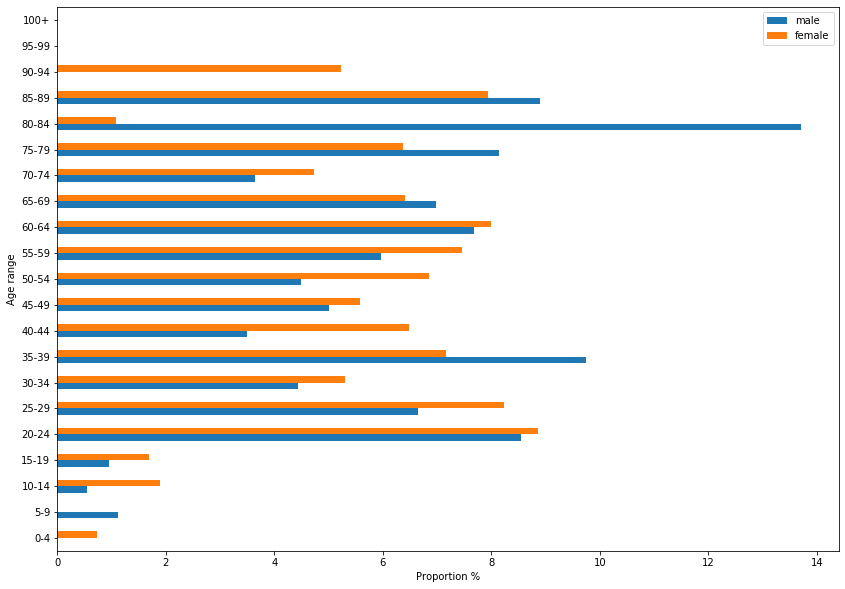

In [0]:
display(df_korea_patients.shape)
plot_normed_distribution(df_korea_patients)

## Normed proportion of **deceased**

(31, 17)

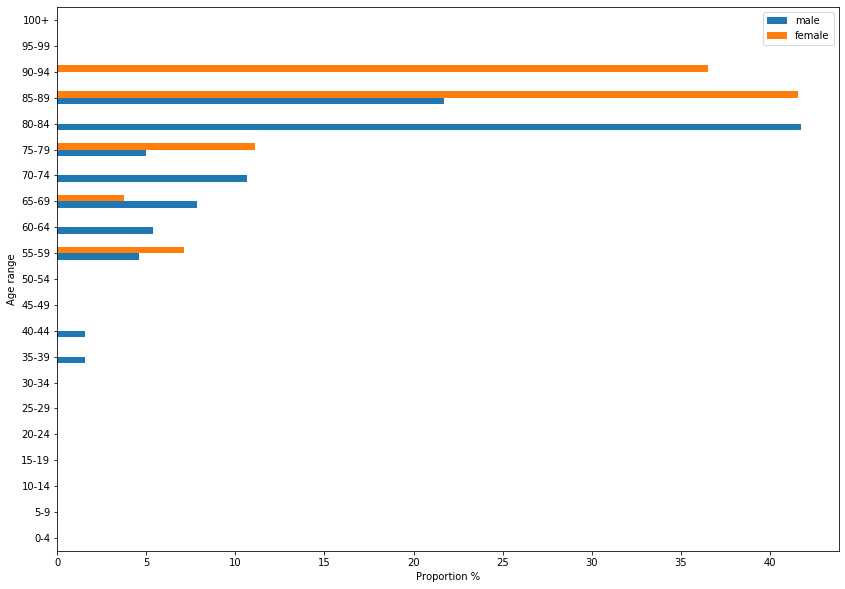

In [0]:
df_deceased = df_korea_patients[df_korea_patients["state"] == "deceased"]
display(df_deceased.shape)
plot_normed_distribution(df_deceased)

## Normed proportion of **released**

(55, 17)

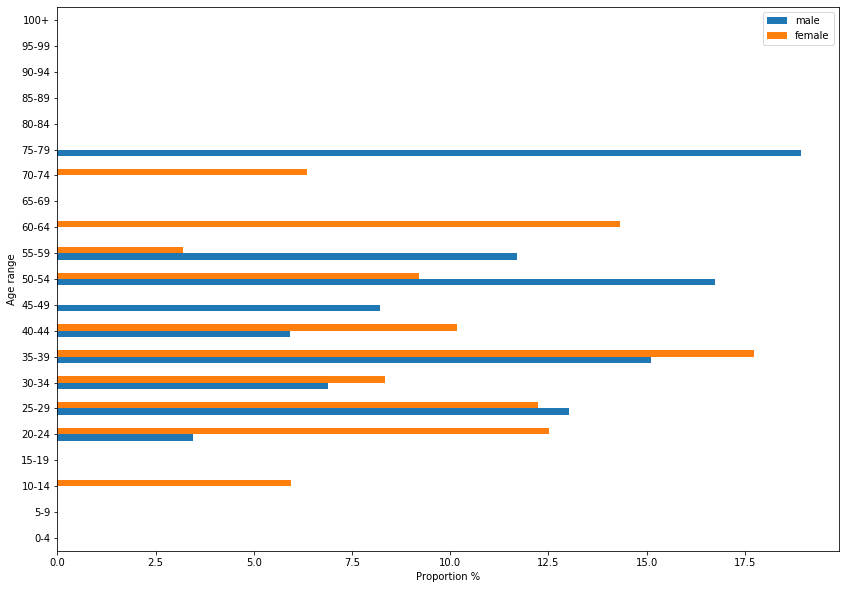

In [0]:
df_released = df_korea_patients[df_korea_patients["state"] == "released"]
display(df_released.shape)
plot_normed_distribution(df_released)